<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px\" align="left">

## Correlated Randomized Benchmarking
---

* **Last Updated:** June 20, 2020
* **Requires:** qiskit-terra 0.14, qiskit-ignis 0.3, qiskit-aer 0.5


## Introduction

**Randomization benchmarking (RB)** is a well-known technique to measure average gate performance by running sequences of random Clifford gates that should return the qubits to the initial state. 
Qiskit Ignis has tools to generate one- and two-qubit Clifford gate sequences simultaneously. If we run simultaneous RB we can look at the decay of correlated Z-Pauli's to extract the weight and locality of errors (see paper XXX).

This notebook gives an example for how to use the ``ignis.verification.randomized_benchmarking`` module to run correlated RB. This particular example shows how to run single qubit simultaneous randomized benchmarking on 5 qubits. 

In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import Qiskit classes classes
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import coherent_unitary_error 

#Import the RB Functions
import os, sys
HOME = "/home/dekelm/Documents/⁨GitHub/⁨qiskit-ignis"
QISKIT_ROOT = HOME
root_dir = os.path.expanduser(QISKIT_ROOT)
if os.path.expanduser(QISKIT_ROOT) not in sys.path:
    sys.path = [os.path.expanduser(QISKIT_ROOT)] + sys.path
import qiskit.ignis.verification.randomized_benchmarking as rb
print(rb.__file__)

#Import the RB Functions
#import qiskit.ignis.verification.randomized_benchmarking as rb

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

/Users/dekelm/opt/anaconda3/lib/python3.7/site-packages/qiskit/ignis/verification/randomized_benchmarking/__init__.py


In [2]:
# -*- coding: utf-8 -*-

# This code is part of Qiskit.
#
# (C) Copyright IBM 2019.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

# pylint: disable=invalid-name

# NOTE: this is because BasicUtils doesn't define any arguments on it's methods
# so the implementations here don't match the abstract class. This needs to
# be fixed or reworked without an abstract class
# pylint: disable=arguments-differ

"""
Functions used for the analysis of randomized benchmarking results.
"""

from abc import ABC, abstractmethod
from scipy.optimize import curve_fit, least_squares
import numpy as np
from qiskit import QiskitError
from qiskit.quantum_info.analysis.average import average_data
from qiskit.ignis.verification.tomography import marginal_counts
from qiskit.ignis.utils import build_counts_dict_from_list

try:
    from matplotlib import pyplot as plt
    HAS_MATPLOTLIB = True
except ImportError:
    HAS_MATPLOTLIB = False


class RBFitterBase(ABC):
    """
        Abstract base class (ABS) for fitters for randomized benchmarking.
    """

    @property
    @abstractmethod
    def raw_data(self):
        """Return raw data."""
        return

    @property
    @abstractmethod
    def cliff_lengths(self):
        """Return clifford lengths."""
        return

    @property
    @abstractmethod
    def ydata(self):
        """Return ydata (means and std devs)."""
        return

    @property
    @abstractmethod
    def fit(self):
        """Return fit."""
        return

    @property
    @abstractmethod
    def rb_fit_fun(self):
        """Return the fit function rb_fit_fun."""
        return

    @property
    @abstractmethod
    def seeds(self):
        """Return the number of loaded seeds."""
        return

    @property
    @abstractmethod
    def results(self):
        """Return all the results."""
        return

    @abstractmethod
    def add_data(self):
        """
        Add a new result. Re calculate the raw data, means and
        fit.
        """

        return

    @abstractmethod
    def calc_data(self):
        """Retrieve probabilities of success from execution results."""

        return

    @abstractmethod
    def calc_statistics(self):
        """Extract averages and std dev from the raw data."""

        return

    @abstractmethod
    def fit_data_pattern(self):
        """
        Fit the RB results of a particular pattern
        to an exponential curve.
        """

        return

    @abstractmethod
    def fit_data(self):
        """
        Fit the RB results to an exponential curve.
        """

        return

    @abstractmethod
    def plot_rb_data(self):
        """
        Plot randomized benchmarking data of a single pattern.

        """

        return


class RBFitter(RBFitterBase):
    """
        Class for fitters for randomized benchmarking.
    """

    def __init__(self, backend_result, cliff_lengths,
                 rb_pattern=None):
        """
        Args:
            backend_result (Result): list of results (qiskit.Result).
            cliff_lengths (list): the Clifford lengths, 2D list i x j where i is the
                number of patterns, j is the number of cliffords lengths.
            rb_pattern (list): the pattern for the RB sequences.
        """
        if rb_pattern is None:
            rb_pattern = [[0]]

        self._cliff_lengths = cliff_lengths
        self._rb_pattern = rb_pattern
        self._raw_data = []
        self._ydata = []
        self._fit = [{} for e in rb_pattern]
        self._nseeds = []
        self._circ_name_type = ''

        self._result_list = []
        self.add_data(backend_result)

    @property
    def raw_data(self):
        """Return raw data."""
        return self._raw_data

    @raw_data.setter
    def raw_data(self, raw_data):
        if raw_data is None:
            self._raw_data = []
        else:
            self._raw_data = raw_data

    @property
    def cliff_lengths(self):
        """Return clifford lengths."""
        return self._cliff_lengths

    @property
    def ydata(self):
        """Return ydata (means and std devs)."""
        return self._ydata

    @ydata.setter
    def ydata(self, ydata):
        if ydata is None:
            self._ydata = []
        else:
            self._ydata = ydata

    @property
    def fit(self):
        """Return fit."""
        return self._fit

    @fit.setter
    def fit(self, fit):
        if fit is None:
            self._fit = []
        else:
            self._fit = fit

    @property
    def rb_fit_fun(self):
        """Return the fit function rb_fit_fun."""
        return self._rb_fit_fun

    @property
    def seeds(self):
        """Return the number of loaded seeds."""
        return self._nseeds

    @property
    def results(self):
        """Return all the results."""
        return self._result_list

    def add_data(self, new_backend_result, rerun_fit=True):
        """
        Add a new result. Re calculate the raw data, means and
        fit.

        Args:
            new_backend_result (list): list of RB results.
            rerun_fit (bool): re calculate the means and fit the result.

        Additional information:
            Assumes that the executed 'result' is
            the output of circuits generated by randomized_benchmarking_seq.
        """

        if new_backend_result is None:
            return

        if not isinstance(new_backend_result, list):
            new_backend_result = [new_backend_result]

        for result in new_backend_result:
            self._result_list.append(result)

            # update the number of seeds *if* new ones
            # added. Note, no checking if we've done all the
            # cliffords
            for rbcirc in result.results:
                nseeds_circ = int(rbcirc.header.name.split('_')[-1])
                if nseeds_circ not in self._nseeds:
                    self._nseeds.append(nseeds_circ)

        if rerun_fit:
            self.calc_data()
            self.calc_statistics()
            self.fit_data()

    @staticmethod
    def _rb_fit_fun(x, a, alpha, b):
        """Function used to fit RB."""
        # pylint: disable=invalid-name
        return a * alpha ** x + b

    def calc_data(self):
        """Retrieve probabilities of success from execution results.

        Outputs results into an internal variable _raw_data which is a
        3-dimensional list, where item (i,j,k) is the probability
        to measure the ground state for the set of qubits in pattern "i"
        for seed no. j and vector length self._cliff_lengths[i][k].

        Additional information:
            Assumes that the executed 'result' is
            the output of circuits generated by randomized_benchmarking_seq.
        """

        # The type of the circuit name, e.g. rb or rb_interleaved
        # as it appears in the result (before _length_%d_seed_%d)
        self._circ_name_type = self._result_list[0].results[0]. \
            header.name.split("_length")[0]

        circ_counts = {}
        circ_shots = {}
        for seed in self._nseeds:
            for circ, _ in enumerate(self._cliff_lengths[0]):
                circ_name = self._circ_name_type + '_length_%d_seed_%d' \
                            % (circ, seed)
                count_list = []
                for result in self._result_list:
                    try:
                        count_list.append(result.get_counts(circ_name))
                    except (QiskitError, KeyError):
                        pass

                circ_counts[circ_name] = \
                    build_counts_dict_from_list(count_list)

                circ_shots[circ_name] = sum(circ_counts[circ_name].values())

        self._raw_data = []
        startind = 0

        for patt_ind in range(len(self._rb_pattern)):

            string_of_0s = ''
            string_of_0s = string_of_0s.zfill(len(self._rb_pattern[patt_ind]))

            self._raw_data.append([])
            endind = startind+len(self._rb_pattern[patt_ind])

            for seedidx, seed in enumerate(self._nseeds):

                self._raw_data[-1].append([])
                for k, _ in enumerate(self._cliff_lengths[patt_ind]):
                    circ_name = self._circ_name_type + '_length_%d_seed_%d' \
                                % (k, seed)
                    counts_subspace = marginal_counts(
                        circ_counts[circ_name],
                        np.arange(startind, endind))
                    self._raw_data[-1][seedidx].append(
                        counts_subspace.get(string_of_0s, 0)
                        / circ_shots[circ_name])
            startind = endind

    def calc_statistics(self):
        """Extract averages and std dev from the raw data (self._raw_data).

        Assumes that self._calc_data has been run. Output into internal
        _ydata variable. ydata is a list of dictionaries (length number of
        patterns). Dictionary ydata[i]:

         * ydata[i]['mean'] is a numpy_array of length n;
           entry j of this array contains the mean probability of
           success over seeds, for vector length
           self._cliff_lengths[i][j].
         * ydata[i]['std'] is a numpy_array of length n;
           entry j of this array contains the std
           of the probability of success over seeds,
           for vector length self._cliff_lengths[i][j].
        """

        self._ydata = []
        for patt_ind in range(len(self._rb_pattern)):
            self._ydata.append({})
            self._ydata[-1]['mean'] = np.mean(self._raw_data[patt_ind], 0)

            if len(self._raw_data[patt_ind]) == 1:  # 1 seed
                self._ydata[-1]['std'] = None
            else:
                self._ydata[-1]['std'] = np.std(self._raw_data[patt_ind], 0)

    def fit_data_pattern(self, patt_ind, fit_guess):
        """
        Fit the RB results of a particular pattern to an exponential curve.

        Args:
            patt_ind (int): index of the data pattern to fit.
            fit_guess (list): guess values for the fit.

        Puts the results into a list of fit dictionaries where each dictionary
        corresponds to a pattern and has fields:

         * ``params`` - three parameters of rb_fit_fun. The middle one is the
           exponent.
         * ``err`` - the error limits of the parameters.
         * ``epc`` - error per Clifford.
        """

        lens = self._cliff_lengths[patt_ind]
        qubits = self._rb_pattern[patt_ind]

        # if at least one of the std values is zero, then sigma is replaced
        # by None
        if not self._ydata[patt_ind]['std'] is None:
            sigma = self._ydata[patt_ind]['std'].copy()
            if len(sigma) - np.count_nonzero(sigma) > 0:
                sigma = None
        else:
            sigma = None
        params, pcov = curve_fit(self._rb_fit_fun, lens,
                                 self._ydata[patt_ind]['mean'],
                                 sigma=sigma,
                                 p0=fit_guess,
                                 bounds=([0, 0, 0], [1, 1, 1]))
        alpha = params[1]  # exponent
        params_err = np.sqrt(np.diag(pcov))
        alpha_err = params_err[1]

        nrb = 2 ** len(qubits)
        epc = (nrb-1)/nrb*(1-alpha)
        epc_err = (nrb-1)/nrb*alpha_err/alpha

        self._fit[patt_ind] = {'params': params, 'params_err': params_err,
                               'epc': epc, 'epc_err': epc_err}

    def fit_data(self):
        """Fit the RB results to an exponential curve.

        Fit each of the patterns. Use the data to construct guess values
        for the fits.

        Puts the results into a list of fit dictionaries where each dictionary
        corresponds to a pattern and has fields:

         * ``params`` - three parameters of rb_fit_fun. The middle one is the
           exponent.
         * ``err`` - the error limits of the parameters.
         * ``epc`` - error per Clifford.

        """

        for patt_ind, _ in enumerate(self._rb_pattern):

            qubits = self._rb_pattern[patt_ind]

            # Should decay to 1/2^n
            fit_guess = [0.95, 0.99, 1/2**len(qubits)]

            # Use the first two points to guess the decay param
            y0 = self._ydata[patt_ind]['mean'][0]
            y1 = self._ydata[patt_ind]['mean'][1]
            dcliff = (self._cliff_lengths[patt_ind][1] -
                      self._cliff_lengths[patt_ind][0])
            dy = ((y1 - fit_guess[2]) /
                  (y0 - fit_guess[2]))
            alpha_guess = dy**(1/dcliff)
            if alpha_guess < 1.0:
                fit_guess[1] = alpha_guess

            if y0 > fit_guess[2]:
                fit_guess[0] = ((y0 - fit_guess[2]) /
                                fit_guess[1]**self._cliff_lengths[patt_ind][0])

            self.fit_data_pattern(patt_ind, tuple(fit_guess))

    def plot_rb_data(self, pattern_index=0, ax=None,
                     add_label=True, show_plt=True):
        """Plot randomized benchmarking data of a single pattern.

        Args:
            pattern_index (int): which RB pattern to plot.
            ax (Axes): plot axis (if passed in).
            add_label (bool): Add an EPC label.
            show_plt (bool): display the plot.

        Raises:
            ImportError: if matplotlib is not installed.
        """

        fit_function = self._rb_fit_fun

        if not HAS_MATPLOTLIB:
            raise ImportError('The function plot_rb_data needs matplotlib. '
                              'Run "pip install matplotlib" before.')

        if ax is None:
            plt.figure()
            ax = plt.gca()

        xdata = self._cliff_lengths[pattern_index]

        # Plot the result for each sequence
        for one_seed_data in self._raw_data[pattern_index]:
            ax.plot(xdata, one_seed_data, color='gray', linestyle='none',
                    marker='x')

        # Plot the mean with error bars
        ax.errorbar(xdata, self._ydata[pattern_index]['mean'],
                    yerr=self._ydata[pattern_index]['std'],
                    color='r', linestyle='--', linewidth=3)

        # Plot the fit
        ax.plot(xdata,
                fit_function(xdata, *self._fit[pattern_index]['params']),
                color='blue', linestyle='-', linewidth=2)
        ax.tick_params(labelsize=14)

        ax.set_xlabel('Clifford Length', fontsize=16)
        ax.set_ylabel('Ground State Population', fontsize=16)
        ax.grid(True)

        if add_label:
            bbox_props = dict(boxstyle="round,pad=0.3",
                              fc="white", ec="black", lw=2)

            ax.text(0.6, 0.9,
                    "alpha: %.3f(%.1e) EPC: %.3e(%.1e)" %
                    (self._fit[pattern_index]['params'][1],
                     self._fit[pattern_index]['params_err'][1],
                     self._fit[pattern_index]['epc'],
                     self._fit[pattern_index]['epc_err']),
                    ha="center", va="center", size=14,
                    bbox=bbox_props, transform=ax.transAxes)

        if show_plt:
            plt.show()


class InterleavedRBFitter(RBFitterBase):
    """
    Class for fitters for interleaved RB, derived from RBFitterBase class.

    Contains two RBFitter objects: the original RBFitter and the
    interleaved RBFitter.
    """

    def __init__(self, original_result, interleaved_result,
                 cliff_lengths, rb_pattern=None):
        """
        Args:
            original_result (list): list of results of the
                original RB sequence (qiskit.Result).
            interleaved_result (list): list of results of the
                interleaved RB sequence (qiskit.Result).
            cliff_lengths (list): the Clifford lengths, 2D list i x j where i
                is the number of patterns, j is the number of cliffords lengths.
            rb_pattern (list): the pattern for the RB sequences.
        """

        self._cliff_lengths = cliff_lengths
        self._rb_pattern = rb_pattern
        self._fit_interleaved = []

        self._rbfit_original = RBFitter(
            original_result, cliff_lengths, rb_pattern)
        self._rbfit_interleaved = RBFitter(
            interleaved_result, cliff_lengths, rb_pattern)

        self.rbfit_std.add_data(original_result)
        self.rbfit_int.add_data(interleaved_result)

        if not (original_result is None and interleaved_result is None):
            self.fit_data()

    @property
    def rbfit_std(self):
        """Return the original RB fitter."""
        return self._rbfit_original

    @property
    def rbfit_int(self):
        """Return the interleaved RB fitter."""
        return self._rbfit_interleaved

    @property
    def cliff_lengths(self):
        """Return clifford lengths."""
        return self._cliff_lengths

    @property
    def fit(self):
        """Return fit as a 2 element list."""
        return [self.rbfit_std.fit, self.rbfit_int.fit]

    @property
    def fit_int(self):
        """Return interleaved fit parameters."""
        return self._fit_interleaved

    @property
    def rb_fit_fun(self):
        """Return the fit function rb_fit_fun."""
        return self.rbfit_std.rb_fit_fun

    @property
    def seeds(self):
        """Return the number of loaded seeds as a
        2 element list."""
        return [self.rbfit_std.seeds, self.rbfit_int.seeds]

    @property
    def results(self):
        """Return all the results as a 2 element list."""
        return [self.rbfit_std.results, self.rbfit_int.results]

    @property
    def ydata(self):
        """Return ydata (means and std devs) as a
        2 element list."""
        return [self.rbfit_std.ydata, self.rbfit_int.ydata]

    @property
    def raw_data(self):
        """Return raw_data as a 2 element list."""
        return [self.rbfit_std.raw_data, self.rbfit_int.raw_data]

    def add_data(self, new_original_result,
                 new_interleaved_result, rerun_fit=True):
        """
        Add a new result.

        Args:
            new_original_result (list): list of RB results of the original circuits.
            new_interleaved_result (list): list of RB results
                of the interleaved circuits.
            rerun_fit (bool): re-calculate the means and fit the result.

        Additional information:
            Assumes that the executed 'result' is
            the output of circuits generated by randomized_benchmarking_seq.
        """
        self.rbfit_std.add_data(new_original_result, rerun_fit)
        self.rbfit_int.add_data(new_interleaved_result, rerun_fit)

        if rerun_fit:
            self.fit_data()

    def calc_data(self):
        """Retrieve probabilities of success from execution results.

        Outputs results into an internal variables: _raw_original_data and
        _raw_interleaved_data
        """
        self.rbfit_std.calc_data()
        self.rbfit_int.calc_data()

    def calc_statistics(self):
        """Extract averages and std dev.

        Output [ydata_original, ydata_interleaved]
        """
        self.rbfit_std.calc_statistics()
        self.rbfit_int.calc_statistics()

    def fit_data_pattern(self, patt_ind, fit_guess, fit_index=0):
        """
        Fit the RB results of a particular pattern to an exponential curve.

        Args:
            patt_ind (int): index of the data to fit.
            fit_guess (list): guess values for the fit.
            fit_index (int): 0 fit the standard data, 1 fit the
                interleaved data.

        """

        if fit_index == 0:
            self.rbfit_std.fit_data_pattern(patt_ind, fit_guess)
        else:
            self.rbfit_int.fit_data_pattern(patt_ind, fit_guess)

    def fit_data(self):
        """
        Fit the interleaved RB results.
        Fit each of the patterns.

        According to the paper: "Efficient measurement of quantum gate
        error by interleaved randomized benchmarking" (arXiv:1203.4550)
        - Equations (4) and (5).

        Puts the results into a list of fit dictionaries:
        where each dictionary corresponds to a pattern and has fields:

            * 'epc_est' - the estimated error per the interleaved Clifford.
            * 'epc_est_error' - the estimated error derived from the params_err.
            * 'systematic_err' - systematic error bound of epc_est.
            * 'systematic_err_L' = epc_est - systematic_err (left error bound).
            * 'systematic_err_R' = epc_est + systematic_err (right error bound).
        """
        self.rbfit_std.fit_data()
        self.rbfit_int.fit_data()
        self._fit_interleaved = []

        for patt_ind, (_, qubits) in enumerate(zip(self._cliff_lengths,
                                                   self._rb_pattern)):
            # calculate nrb=d=2^n:
            nrb = 2 ** len(qubits)

            # Calculate alpha (=p) and alpha_c (=p_c):
            alpha = self.rbfit_std.fit[patt_ind]['params'][1]
            alpha_c = self.rbfit_int.fit[patt_ind]['params'][1]
            # Calculate their errors:
            alpha_err = self.rbfit_std.fit[patt_ind]['params_err'][1]
            alpha_c_err = self.rbfit_int.fit[patt_ind]['params_err'][1]

            # Calculate epc_est (=r_c^est) - Eq. (4):
            epc_est = (nrb - 1) * (1 - alpha_c / alpha) / nrb

            # Calculate the systematic error bounds - Eq. (5):
            systematic_err_1 = (nrb - 1) * (abs(alpha - alpha_c / alpha)
                                            + (1 - alpha)) / nrb
            systematic_err_2 = 2 * (nrb * nrb - 1) * (1 - alpha) / \
                (alpha * nrb * nrb) + 4 * (np.sqrt(1 - alpha)) * \
                (np.sqrt(nrb * nrb - 1)) / alpha
            systematic_err = min(systematic_err_1, systematic_err_2)
            systematic_err_L = epc_est - systematic_err
            systematic_err_R = epc_est + systematic_err

            # Calculate epc_est_error
            alpha_err_sq = (alpha_err / alpha) * (alpha_err / alpha)
            alpha_c_err_sq = (alpha_c_err / alpha_c) * (alpha_c_err / alpha_c)
            epc_est_err = ((nrb - 1) / nrb) * (alpha_c / alpha) \
                * (np.sqrt(alpha_err_sq + alpha_c_err_sq))

            self._fit_interleaved.append({'alpha': alpha,
                                          'alpha_err': alpha_err,
                                          'alpha_c': alpha_c,
                                          'alpha_c_err': alpha_c_err,
                                          'epc_est': epc_est,
                                          'epc_est_err': epc_est_err,
                                          'systematic_err':
                                              systematic_err,
                                          'systematic_err_L':
                                              systematic_err_L,
                                          'systematic_err_R':
                                              systematic_err_R})

    def plot_rb_data(self, pattern_index=0, ax=None,
                     add_label=True, show_plt=True):
        """
        Plot interleaved randomized benchmarking data of a single pattern.

        Args:
            pattern_index (int): which RB pattern to plot.
            ax (Axes): plot axis (if passed in).
            add_label (bool): Add an EPC label.
            show_plt (bool): display the plot.

        Raises:
            ImportError: if matplotlib is not installed.
        """

        if not HAS_MATPLOTLIB:
            raise ImportError('The function plot_interleaved_rb_data \
            needs matplotlib. Run "pip install matplotlib" before.')

        if ax is None:
            plt.figure()
            ax = plt.gca()

        xdata = self._cliff_lengths[pattern_index]

        # Plot the original and interleaved result for each sequence
        for one_seed_data in self.raw_data[0][pattern_index]:
            ax.plot(xdata, one_seed_data, color='blue', linestyle='none',
                    marker='x')
        for one_seed_data in self.raw_data[1][pattern_index]:
            ax.plot(xdata, one_seed_data, color='red', linestyle='none',
                    marker='+')

        # Plot the fit
        std_fit_function = self.rbfit_std.rb_fit_fun
        int_fit_function = self.rbfit_int.rb_fit_fun
        ax.plot(xdata, std_fit_function(xdata,
                                        *self.fit[0][pattern_index]['params']),
                color='blue', linestyle='-', linewidth=2,
                label='Standard RB')
        ax.tick_params(labelsize=14)
        ax.plot(xdata, int_fit_function(xdata,
                                        *self.fit[1][pattern_index]['params']),
                color='red', linestyle='-', linewidth=2,
                label='Interleaved RB')
        ax.tick_params(labelsize=14)

        ax.set_xlabel('Clifford Length', fontsize=16)
        ax.set_ylabel('Ground State Population', fontsize=16)
        ax.grid(True)
        ax.legend(loc='lower left')

        if add_label:
            bbox_props = dict(boxstyle="round,pad=0.3",
                              fc="white", ec="black", lw=2)

            ax.text(0.6, 0.9,
                    "alpha: %.3f(%.1e) alpha_c: %.3e(%.1e) \n \
                    EPC_est: %.3e(%.1e)" %
                    (self._fit_interleaved[pattern_index]['alpha'],
                     self._fit_interleaved[pattern_index]['alpha_err'],
                     self._fit_interleaved[pattern_index]['alpha_c'],
                     self._fit_interleaved[pattern_index]['alpha_c_err'],
                     self._fit_interleaved[pattern_index]['epc_est'],
                     self._fit_interleaved[pattern_index]['epc_est_err']),
                    ha="center", va="center", size=14,
                    bbox=bbox_props, transform=ax.transAxes)

        if show_plt:
            plt.show()


class PurityRBFitter(RBFitterBase):
    """
    Class for fitter for purity RB.

    Derived from RBFitterBase class.
    """

    def __init__(self, purity_result, npurity, cliff_lengths,
                 rb_pattern=None):
        """
        Args:
            purity_result (list): list of results of the
                3^n purity RB sequences per seed (qiskit.Result).
            npurity (int): equals 3^n (where n is the dimension).
            cliff_lengths (list): the Clifford lengths, 2D list i x j where i is the
                number of patterns, j is the number of cliffords lengths.
            rb_pattern (list): the pattern for the RB sequences.
        """
        if rb_pattern is None:
            rb_pattern = [[0]]

        self._cliff_lengths = cliff_lengths
        self._rb_pattern = rb_pattern
        self._npurity = npurity
        self._nq = len(rb_pattern[0])  # all patterns have same length

        self._fit = [{} for e in rb_pattern]
        self._circ_name_type = ''

        self._zdict_ops = []
        self.add_zdict_ops()

        # rb purity fitter
        self._rbfit_purity = RBFitter(purity_result, cliff_lengths,
                                      rb_pattern)
        self.add_data(purity_result)

    @property
    def rbfit_pur(self):
        """Return the purity RB fitter."""
        return self._rbfit_purity

    @property
    def raw_data(self):
        """Return raw data."""
        return self.rbfit_pur.raw_data

    @property
    def cliff_lengths(self):
        """Return clifford lengths."""
        return self.cliff_lengths

    @property
    def ydata(self):
        """Return ydata (means and std devs)."""
        return self.rbfit_pur.ydata

    @property
    def fit(self):
        """Return the purity fit parameters."""
        return self.rbfit_pur.fit

    @property
    def rb_fit_fun(self):
        """Return the fit function rb_fit_fun."""
        return self.rbfit_pur.rb_fit_fun

    @property
    def seeds(self):
        """Return the number of loaded seeds."""
        return self.rbfit_pur.seeds

    @property
    def results(self):
        """Return all the results."""
        return self.rbfit_pur.results

    @staticmethod
    def _rb_pur_fit_fun(x, a, alpha, b):
        """Function used to fit purity rb."""
        # pylint: disable=invalid-name
        return a * alpha ** (2 * x) + b

    @staticmethod
    def F234(n, a, b):
        """Function than maps:
        2^n x 3^n --> 4^n ,
        namely:
        (a,b) --> c where
        a in 2^n, b in 3^n, c in 4^n
        """
        # 0 <--> I
        # 1 <--> X
        # 2 <--> Y
        # 3 <--> Z
        LUT = [[0, 0, 0], [3, 1, 2]]

        # compute bits
        aseq = []
        bseq = []

        aa = a
        bb = b
        for i in range(n):
            aseq.append(np.mod(aa, 2))
            bseq.append(np.mod(bb, 3))
            aa = np.floor_divide(aa, 2)
            bb = np.floor_divide(bb, 3)

        c = 0
        for i in range(n):
            c += (4 ** i) * LUT[aseq[i]][bseq[i]]

        return c

    def add_zdict_ops(self):
        """Creating all Z-correlators
        in order to compute the expectation values."""
        statedict = {("{0:0%db}" % self._nq).format(i): 1 for i in
                     range(2 ** self._nq)}

        for i in range(2 ** self._nq):
            self._zdict_ops.append(statedict.copy())
            for j in range(2 ** self._nq):
                if bin(i & j).count('1') % 2 != 0:
                    self._zdict_ops[-1][("{0:0%db}"
                                         % self._nq).format(j)] = -1

    def add_data(self, new_purity_result, rerun_fit=True):
        """
        Add a new result.

        Args:
            new_purity_result (list): list of RB results of the
                purity RB circuits.
            rerun_fit (bool): re-calculate the means and fit the result.

        Additional information:
            Assumes that the executed 'result' is
            the output of circuits generated by randomized_benchmarking_seq
            where is_purity = True.
        """

        if new_purity_result is None:
            return

        self.rbfit_pur.add_data(new_purity_result, rerun_fit)

        if rerun_fit:
            self.calc_data()
            self.calc_statistics()
            self.fit_data()

    def calc_data(self):
        """
        Retrieve probabilities of success from execution results.

        Measure the purity calculation into an internal variable _raw_data
        which is a 3-dimensional list, where item (i,j,k) is the purity
        of the set of qubits in pattern "i"
        for seed no. j and vector length self._cliff_lengths[i][k].

        Additional information:
            Assumes that the executed 'result' is
            the output of circuits generated by randomized_benchmarking_seq,
        """
        circ_counts = {}
        circ_shots = {}
        result_count = 0

        # Calculating the result output
        for _, seed in enumerate(self.rbfit_pur.seeds):

            for pur in range(self._npurity):

                self._circ_name_type = self.rbfit_pur.results[
                    result_count].results[0].header.name.split("_length")[0]
                result_count += 1

                for circ, _ in enumerate(self._cliff_lengths[0]):
                    circ_name = self._circ_name_type + '_length_%d_seed_%d' \
                                % (circ, seed)
                    count_list = []
                    for result in self.rbfit_pur.results:
                        try:
                            count_list.append(result.get_counts(circ_name))
                        except (QiskitError, KeyError):
                            pass

                    circ_name = 'rb_purity_' + str(pur) + \
                                '_length_%d_seed_%d' % (circ, seed)

                    circ_counts[circ_name] = build_counts_dict_from_list(
                        count_list)
                    circ_shots[circ_name] = sum(circ_counts[circ_name].
                                                values())

        # Calculating raw_data
        self.rbfit_pur.raw_data = []
        startind = 0
        # for each pattern
        for patt_ind, _ in enumerate(self._rb_pattern):

            endind = startind + len(self._rb_pattern[patt_ind])
            self.rbfit_pur.raw_data.append([])

            # for each seed
            for seedidx, seed in enumerate(self.rbfit_pur.seeds):
                self.rbfit_pur.raw_data[-1].append([])

                # for each length
                for k, _ in enumerate(self._cliff_lengths[0]):

                    # vector of the 4^n correlators and counts
                    corr_vec = [0] * (4 ** self._nq)
                    count_vec = [0] * (4 ** self._nq)
                    # corr_list = [[] for e in range(4 ** self._nq)]

                    for pur in range(self._npurity):

                        circ_name = 'rb_purity_' + str(pur) + \
                                    '_length_%d_seed_%d' % (k, seed)

                        # marginal counts for the pattern
                        counts_subspace = marginal_counts(
                            circ_counts[circ_name],
                            np.arange(startind, endind))

                        # calculating the vector of 4^n correlators
                        for indcorr in range(2 ** self._nq):
                            zcorr = average_data(counts_subspace,
                                                 self._zdict_ops[indcorr])
                            zind = self.F234(self._nq, indcorr, pur)

                            corr_vec[zind] += zcorr
                            count_vec[zind] += 1

                    # calculating the purity
                    purity = 0
                    for idx, _ in enumerate(corr_vec):
                        purity += (corr_vec[idx]/count_vec[idx]) ** 2
                    purity = purity / (2 ** self._nq)

                    self.rbfit_pur.raw_data[-1][seedidx].append(purity)

            startind = endind

    def calc_statistics(self):
        """Extract averages and std dev from the raw data (self._raw_data).

        Assumes that self._calc_data has been run. Output into internal
        _ydata variable. ydata is a list of dictionaries (length number of
        patterns):

        Dictionary ydata[i]:

         * ydata[i]['mean'] is a numpy_array of length n;
           entry j of this array contains the mean probability of
           success over seeds, for vector length
           self._cliff_lengths[i][j].
         * ydata[i]['std'] is a numpy_array of length n;
           entry j of this array contains the std
           of the probability of success over seeds,
           for vector length self._cliff_lengths[i][j].

        """
        self.rbfit_pur.calc_statistics()

    def fit_data_pattern(self, patt_ind, fit_guess):
        """
        Fit the RB results of a particular pattern to an exponential curve.

        Args:
            patt_ind (int): index of the subsystem to fit.
            fit_guess (list): guess values for the fit.

        Puts the results into a list of fit dictionaries where each dictionary
        corresponds to a pattern and has fields:

         * ``params`` - three parameters of rb_fit_fun. The middle one is the
           exponent.
         * ``err`` - the error limits of the parameters.
        """
        self.rbfit_pur.fit_data_pattern(patt_ind, fit_guess)

    def fit_data(self):
        """Fit the Purity RB results to an exponential curve.

        Use the data to construct guess values for the fits.

        Puts the results into a list of fit dictionaries where each dictionary
        corresponds to a pattern and has fields:

         * ``params`` - three parameters of rb_fit_fun. The middle one is the
           exponent.
         * ``err`` - the error limits of the parameters.
         * ``epc`` - Error per Clifford.
         * ``pepc`` - Purity Error per Clifford.
        """
        self.rbfit_pur.fit_data()

        for patt_ind, (_, _) in enumerate(zip(self._cliff_lengths,
                                              self._rb_pattern)):
            # Calculate alpha (=p):
            # fitting the curve: A*p^(2m)+B
            # where m is the Clifford length
            alpha = self.rbfit_pur.fit[patt_ind]['params'][1]
            alpha_pur = np.sqrt(alpha)
            self.rbfit_pur.fit[patt_ind]['params'][1] = alpha_pur

            # calculate the error of alpha
            alpha_err = self.rbfit_pur.fit[patt_ind]['params_err'][1]
            alpha_pur_err = alpha_err / (2 * np.sqrt(alpha_pur))
            self.rbfit_pur.fit[patt_ind]['params_err'][1] = \
                alpha_pur_err

            # calculate purity error per clifford (pepc)
            nrb = 2 ** self._nq
            pepc = (nrb-1)/nrb * (1-alpha_pur)
            self.rbfit_pur.fit[patt_ind]['pepc'] = \
                pepc

            pepc_err = (nrb-1)/nrb * alpha_pur_err / alpha_pur
            self.rbfit_pur.fit[patt_ind]['pepc_err'] = \
                pepc_err

    def plot_rb_data(self, pattern_index=0, ax=None,
                     add_label=True, show_plt=True):
        """Plot purity RB data of a single pattern."""
        fit_function = self._rb_pur_fit_fun

        if not HAS_MATPLOTLIB:
            raise ImportError('The function plot_rb_data needs matplotlib. '
                              'Run "pip install matplotlib" before.')

        if ax is None:
            plt.figure()
            ax = plt.gca()

        xdata = self._cliff_lengths[pattern_index]

        # Plot the result for each sequence
        for one_seed_data in self.rbfit_pur.raw_data[pattern_index]:
            ax.plot(xdata, one_seed_data, color='gray', linestyle='none',
                    marker='x')

        # Plot the mean with error bars
        ax.errorbar(xdata, self.rbfit_pur.ydata[pattern_index]['mean'],
                    yerr=self.rbfit_pur.ydata[pattern_index]['std'],
                    color='r', linestyle='--', linewidth=3)

        # Plot the fit
        ax.plot(xdata,
                fit_function(xdata, *self.rbfit_pur.fit[pattern_index][
                    'params']),
                color='blue', linestyle='-', linewidth=2)
        ax.tick_params(labelsize=14)

        ax.set_xlabel('Clifford Length', fontsize=16)
        ax.set_ylabel('Trace of Rho Square', fontsize=16)
        ax.grid(True)

        if add_label:
            bbox_props = dict(boxstyle="round,pad=0.3",
                              fc="white", ec="black", lw=2)

            ax.text(0.6, 0.9,
                    "alpha: %.3f(%.1e) PEPC: %.3e(%.1e)" %
                    (self.rbfit_pur.fit[pattern_index]['params'][1],
                     self.rbfit_pur.fit[pattern_index]['params_err'][1],
                     self.rbfit_pur.fit[pattern_index]['pepc'],
                     self.rbfit_pur.fit[pattern_index]['pepc_err']),
                    ha="center", va="center", size=14,
                    bbox=bbox_props, transform=ax.transAxes)

        if show_plt:
            plt.show()


class CNOTDihedralRBFitter(RBFitterBase):
    """Class for fitters for non-Clifford CNOT-Dihedral RB.

    Derived from RBFitterBase class. Contains two RBFitter objects.
    """

    def __init__(self, cnotdihedral_Z_result, cnotdihedral_X_result,
                 elmnts_lengths, rb_pattern=None):
        """
        Args:
            cnotdihedral_Z_result (qiskit.Result): list of results of the
                RB sequence that measures the ground state.
            cnotdihedral_X_result (qiskit.Result): list of results of the
                RB sequence that measures the :math:`|+...+>` state.
            elmnts_lengths (list): the group elements lengths,
                2D list i x j where i is the number of patterns,
                j is the number of elements lengths.
            rb_pattern (list): the pattern for the RB sequences.
        """

        # Initialize a new CNOTDihedralRBFitter.
        self._cliff_lengths = elmnts_lengths
        self._rb_pattern = rb_pattern
        self._fit_cnotdihedral = []

        self._rbfit_Z = RBFitter(
            cnotdihedral_Z_result, elmnts_lengths, rb_pattern)
        self._rbfit_X = RBFitter(
            cnotdihedral_X_result, elmnts_lengths, rb_pattern)

        self.rbfit_Z.add_data(cnotdihedral_Z_result)
        self.rbfit_X.add_data(cnotdihedral_X_result)

        if not (cnotdihedral_Z_result is None and
                cnotdihedral_X_result is None):
            self.fit_data()

    @property
    def rbfit_Z(self):
        """Return the cnotdihedral Z fitter."""
        return self._rbfit_Z

    @property
    def rbfit_X(self):
        """Return the cnotdihedral X fitter."""
        return self._rbfit_X

    @property
    def cliff_lengths(self):
        """Return group elements lengths."""
        return self._cliff_lengths

    @property
    def fit(self):
        """Return fit as a 2 element list."""
        return [self.rbfit_Z.fit, self.rbfit_X.fit]

    @property
    def fit_cnotdihedral(self):
        """Return cnotdihedral fit parameters."""
        return self._fit_cnotdihedral

    @property
    def rb_fit_fun(self):
        """Return the fit function rb_fit_fun."""
        return self.rbfit_Z.rb_fit_fun

    @property
    def seeds(self):
        """Return the number of loaded seeds as a
        2 element list."""
        return [self.rbfit_Z.seeds, self.rbfit_X.seeds]

    @property
    def results(self):
        """Return all the results as a 2 element list."""
        return [self.rbfit_Z.results, self.rbfit_X.results]

    @property
    def ydata(self):
        """Return ydata (means and std devs)
        as a 2 element list."""
        return [self.rbfit_Z.ydata, self.rbfit_X.ydata]

    @property
    def raw_data(self):
        """Return raw_data as 2 element list."""
        return [self.rbfit_Z.raw_data, self.rbfit_X.raw_data]

    def add_data(self, new_cnotdihedral_Z_result,
                 new_cnotdihedral_X_result, rerun_fit=True):
        """
        Add a new result.

        Args:
            new_cnotdihedral_Z_result (list): list of rb results
                of the cnot-dihedral Z circuits.
            new_cnotdihedral_X_result (list): list of rb results
                of the cnot-dihedral X circuits.
            rerun_fit (bool): re-calculate the means and fit the result.

        Additional information:
            Assumes that the executed 'result' is
            the output of circuits generated by randomized_benchmarking_seq.
        """
        self.rbfit_Z.add_data(new_cnotdihedral_Z_result, rerun_fit)
        self.rbfit_X.add_data(new_cnotdihedral_X_result, rerun_fit)

        if rerun_fit:
            self.fit_data()

    def calc_data(self):
        """
        Retrieve probabilities of success from execution results.
        Outputs results into an internal variable: _raw_data .
        """
        self.rbfit_Z.calc_data()
        self.rbfit_X.calc_data()

    def calc_statistics(self):
        """
        Extract averages and std dev.
        Outputs results into an internal variable: _ydata .
        """
        self.rbfit_Z.calc_statistics()
        self.rbfit_X.calc_statistics()

    def fit_data_pattern(self, patt_ind, fit_guess, fit_index=0):
        """
        Fit the RB results of a particular pattern
        to an exponential curve.

        Args:
            patt_ind (int): index of the data pattern to fit.
            fit_guess (list): guess values for the fit.
            fit_index (int): 0 fit the standard data, 1 fit the
                interleaved data.
        """

        if fit_index == 0:
            self.rbfit_Z.fit_data_pattern(patt_ind, fit_guess)
        else:
            self.rbfit_X.fit_data_pattern(patt_ind, fit_guess)

    def fit_data(self):
        """Fit the non-Clifford cnot-dihedral RB results.

        Fit each of the patterns.
        According to the paper:

        `Scalable randomized benchmarking of non-Clifford gates
        <https://www.nature.com/articles/npjqi201612>`_

        Returns:
            list: A list of dictionaries where each dictionary corresponds to
            a pattern and has fields:

                 * ``alpha`` - alpha parameter of the non-Clifford
                   cnot-dihedral RB.
                 * ``'alpha_err`` - the error of the alpha parameter of
                   the non-Clifford cnot-dihedral RB.
                 * ``epg_est`` - the estimated error per a CNOT-dihedral
                   element.
                 * ``epg_est_error`` - the estimated error derived from the
                   params_err.

        """
        self.rbfit_Z.fit_data()
        self.rbfit_X.fit_data()
        self._fit_cnotdihedral = []

        for patt_ind, (_, qubits) in enumerate(zip(self._cliff_lengths,
                                                   self._rb_pattern)):
            # calculate nrb=d=2^n:
            nrb = 2 ** len(qubits)

            # Calculate alpha_Z and alpha_R:
            alpha_Z = self.rbfit_Z.fit[patt_ind]['params'][1]
            alpha_R = self.rbfit_X.fit[patt_ind]['params'][1]
            # Calculate their errors:
            alpha_Z_err = self.rbfit_Z.fit[patt_ind]['params_err'][1]
            alpha_R_err = self.rbfit_X.fit[patt_ind]['params_err'][1]

            # Calculate alpha:
            alpha = (alpha_Z + nrb * alpha_R) / (nrb + 1)

            # Calculate alpha_err:
            alpha_Z_err_sq = (alpha_Z_err / alpha_Z / (nrb + 1)) ** 2
            alpha_R_err_sq = (nrb * alpha_R_err / alpha_R / (nrb + 1)) ** 2
            alpha_err = np.sqrt(alpha_Z_err_sq + alpha_R_err_sq)

            # Calculate epg_est:
            epg_est = (nrb - 1) * (1 - alpha) / nrb

            # Calculate epg_est_error
            epg_est_err = (nrb - 1) / nrb * alpha_err / alpha

            self._fit_cnotdihedral.append({'alpha': alpha,
                                           'alpha_err': alpha_err,
                                           'epg_est': epg_est,
                                           'epg_est_err': epg_est_err})

    def plot_rb_data(self, pattern_index=0, ax=None,
                     add_label=True, show_plt=True):
        """
        Plot non-Clifford cnot-dihedral randomized benchmarking data
        of a single pattern.

        Args:
            pattern_index (int): which RB pattern to plot.
            ax (Axes): plot axis (if passed in).
            add_label (bool): Add an EPG label.
            show_plt (bool): display the plot.

        Raises:
            ImportError: if matplotlib is not installed.
        """

        if not HAS_MATPLOTLIB:
            raise ImportError('The function plot_interleaved_rb_data \
            needs matplotlib. Run "pip install matplotlib" before.')

        if ax is None:
            plt.figure()
            ax = plt.gca()

        xdata = self._cliff_lengths[pattern_index]

        # Plot the original and interleaved result for each sequence
        for one_seed_data in self.raw_data[0][pattern_index]:
            ax.plot(xdata, one_seed_data, color='blue', linestyle='none',
                    marker='x')
        for one_seed_data in self.raw_data[1][pattern_index]:
            ax.plot(xdata, one_seed_data, color='red', linestyle='none',
                    marker='+')

        # Plot the fit
        rbfit_Z_function = self.rbfit_Z.rb_fit_fun
        rbfit_X_function = self.rbfit_X.rb_fit_fun
        ax.plot(xdata, rbfit_Z_function(xdata,
                                        *self.fit[0]
                                        [pattern_index]['params']),
                color='blue', linestyle='-', linewidth=2,
                label='Measure state |0...0>')
        ax.tick_params(labelsize=14)
        ax.plot(xdata, rbfit_X_function(xdata,
                                        *self.fit[1]
                                        [pattern_index]['params']),
                color='red', linestyle='-', linewidth=2,
                label='Measure state |+...+>')
        ax.tick_params(labelsize=14)

        ax.set_xlabel('CNOT-Dihedral Length', fontsize=16)
        ax.set_ylabel('Ground State Population', fontsize=16)
        ax.grid(True)
        ax.legend(loc='lower left')

        if add_label:
            bbox_props = dict(boxstyle="round,pad=0.3",
                              fc="white", ec="black", lw=2)

            ax.text(0.6, 0.9,
                    "alpha: %.3f(%.1e) EPG_est: %.3e(%.1e)" %
                    (self._fit_cnotdihedral[pattern_index]['alpha'],
                     self._fit_cnotdihedral[pattern_index]['alpha_err'],
                     self._fit_cnotdihedral[pattern_index]['epg_est'],
                     self._fit_cnotdihedral[pattern_index]['epg_est_err']),
                    ha="center", va="center", size=14,
                    bbox=bbox_props, transform=ax.transAxes)

        if show_plt:
            plt.show()

class CorrelatedRBFitter(RBFitterBase):
    """
        Class for fitters for correlated randomized benchmarking
    """

    def __init__(self, backend_result, cliff_lengths,
                 rb_pattern, max_weight=-1):
        """
        Args:
            backend_result: list of results (qiskit.Result).
            cliff_lengths: the Clifford lengths, 2D list i x j where i is the
                number of patterns, j is the number of cliffords lengths
            rb_pattern: the pattern for the rb sequences.
            max_weight: maximum weight to fit (-1 fit all)
        """

        #WARNING: Haven't implemented max_weight, max_distance yet!!

        #calculate all possible subsystem strings
        self._n_partitions = len(rb_pattern)
        self._n_subsystems = 2**self._n_partitions-1
        self._subsystems = []
        self._subsystems2 = []
        for i in range(self._n_subsystems):
            # this gives the correlator in the subsystem
            # representation
            self._subsystems.append(("{0:0%db}"%self._n_partitions).format(i+1))

            # expand into the full qubit representation
            # and save as an integer
            tmplist2 = []
            for ii in range(self._n_partitions):
                for kk in range(len(rb_pattern[ii])):
                    tmplist2.append(self._subsystems[-1][ii])

            self._subsystems2.append(int(''.join(tmplist2), base=2))

        self._r_coeff = None

        #clifford_lengths need to be the same in all patterns
        self._cliff_lengths = cliff_lengths

        self._rb_pattern = rb_pattern
        self._nq = sum([len(i) for i in rb_pattern])

        statedict = {("{0:0%db}"%self._nq).format(i): 1 for i in range(2**self._nq)}

        self._zdict_ops = []
        for subind, subsys in enumerate(self._subsystems):
            self._zdict_ops.append(statedict.copy())
            for i in range(2**self._nq):
                #if the operator (expressed as an integer) and the state
                #overlap is even then the z operator is '1'
                #otherwise it's -1
                if bin(i & self._subsystems2[subind]).count('1') % 2 != 0:
                    self._zdict_ops[-1][("{0:0%db}"%self._nq).format(i)] = -1




        self._raw_data = []
        self._ydata = []
        self._fit = [{} for e in self._subsystems]
        self._epsilons = []
        self._nseeds = []
        self._circ_name_type = ''

        self._result_list = []
        self.add_data(backend_result)

    @property
    def raw_data(self):
        """Return raw data."""
        return self._raw_data

    @property
    def cliff_lengths(self):
        """Return clifford lengths."""
        return self.cliff_lengths

    @property
    def ydata(self):
        """Return ydata (means and std devs)."""
        return self._ydata

    @property
    def fit(self):
        """Return fit, list."""
        return self._fit

    @property
    def fit_alphas(self):
        alphadict = {}
        for i, j in enumerate(self._subsystems):
            alphadict[j] = self.fit[i]['params'][1]
        return alphadict

    @property
    def fit_epsilon(self):
        return self._epsilons

    @property
    def rb_fit_fun(self):
        """Return the function rb_fit_fun."""
        return self._rb_fit_fun

    @property
    def seeds(self):
        """Return the number of loaded seeds."""
        return self._nseeds

    @property
    def results(self):
        """Return all the results."""
        return self._result_list

    def add_data(self, new_backend_result, rerun_fit=True):
        """
        Add a new result. Re calculate the raw data, means and
        fit.
        Args:
            new_backend_result: list of rb results
            rerun_fit: re caculate the means and fit the result
        Additional information:
            Assumes that 'result' was executed is
            the output of circuits generated by randomized_becnhmarking_seq,
        """

        if new_backend_result is None:
            return

        if not isinstance(new_backend_result, list):
            new_backend_result = [new_backend_result]

        for result in new_backend_result:
            self._result_list.append(result)

            # update the number of seeds *if* new ones
            # added. Note, no checking if we've done all the
            # cliffords
            for rbcirc in result.results:
                nseeds_circ = int(rbcirc.header.name.split('_')[-1])
                if nseeds_circ not in self._nseeds:
                    self._nseeds.append(nseeds_circ)

#        for result in self._result_list:
#            if not len(result.results) == len(self._cliff_lengths[0]):
#                raise ValueError(
#                    "The number of clifford lengths must match the number of "
#                    "results")

        if rerun_fit:
            self.calc_data()
            self.calc_statistics()
            self.fit_data()

    @staticmethod
    def _rb_fit_fun(x, a, alpha, b):
        """Function used to fit rb."""
        # pylint: disable=invalid-name
        return a * alpha ** x + b

    def calc_data(self):
        """
        Measure the correlators into an internal variable _raw_data
        which is a 3-dimensional
        list, where item (i,j,k) is the probability to measure the "i"
        correlator for seed no. j and vector length
        self._cliff_lengths[i][k].
        Additional information:
            Assumes that 'result' was executed is
            the output of circuits generated by randomized_becnhmarking_seq,
        """

        # The type of the circuit name, e.g. rb or rb_interleaved
        # as it appears in the result (before _length_%d_seed_%d)
        self._circ_name_type = self._result_list[0].results[0]. \
            header.name.split("_length")[0]

        circ_counts = {}
        circ_shots = {}
        for seed in self._nseeds:
            for circ, _ in enumerate(self._cliff_lengths[0]):
                circ_name = self._circ_name_type + '_length_%d_seed_%d' \
                            % (circ, seed)
                count_list = []
                for result in self._result_list:
                    try:
                        count_list.append(result.get_counts(circ_name))
                    except (QiskitError, KeyError):
                        pass

                circ_counts[circ_name] = \
                    build_counts_dict_from_list(count_list)

                circ_shots[circ_name] = sum(circ_counts[circ_name].values())

        self._raw_data = []

        for sub_ind, subsys in enumerate(self._subsystems):

            self._raw_data.append([])

            for seedidx, seed in enumerate(self._nseeds):

                self._raw_data[-1].append([])
                for k, _ in enumerate(self._cliff_lengths[0]):
                    circ_name = self._circ_name_type + '_length_%d_seed_%d' \
                                % (k, seed)

                    zcorr = average_data(circ_counts[circ_name],
                                         self._zdict_ops[sub_ind])

                    self._raw_data[-1][seedidx].append(zcorr)


    def calc_statistics(self):
        """
        Extract averages and std dev from the raw data (self._raw_data).
        Assumes that self._calc_data has been run. Output into internal
        _ydata variable:
            ydata is a list of dictionaries (length number of patterns).
            Dictionary ydata[i]:
            ydata[i]['mean'] is a numpy_array of length n;
                        entry j of this array contains the mean probability of
                        success over seeds, for vector length
                        self._cliff_lengths[i][j].
            And ydata[i]['std'] is a numpy_array of length n;
                        entry j of this array contains the std
                        of the probability of success over seeds,
                        for vector length self._cliff_lengths[i][j].
        """

        self._ydata = []
        for sub_ind in range(len(self._subsystems)):
            self._ydata.append({})
            self._ydata[-1]['mean'] = np.mean(self._raw_data[sub_ind], 0)

            if len(self._raw_data[sub_ind]) == 1:  # 1 seed
                self._ydata[-1]['std'] = None
            else:
                self._ydata[-1]['std'] = np.std(self._raw_data[sub_ind], 0)

    def fit_data_pattern(self, patt_ind, fit_guess):
        """
        Fit the RB results of a particular pattern
        to an exponential curve. For correlated RB this means
        fit for a particular subsystem
        Args:
            patt_ind: index of the subsystem to fit
            fit_guess: guess values for the fit
        Puts the results into a list of fit dictionaries:
            where each dictionary corresponds to a pattern and has fields:
            'params' - three parameters of rb_fit_fun. The middle one is the
                       exponent.
            'err' - the error limits of the parameters.
        """

        lens = self._cliff_lengths[0]

        # if at least one of the std values is zero, then sigma is replaced
        # by None
        if not self._ydata[patt_ind]['std'] is None:
            sigma = self._ydata[patt_ind]['std'].copy()
            if len(sigma) - np.count_nonzero(sigma) > 0:
                sigma = None
        else:
            sigma = None
        params, pcov = curve_fit(self._rb_fit_fun, lens,
                                 self._ydata[patt_ind]['mean'],
                                 sigma=sigma,
                                 p0=fit_guess,
                                 bounds=([-2, 0, -0.5], [2, 1, 0.5]))

        params_err = np.sqrt(np.diag(pcov))

        self._fit[patt_ind] = {'params': params, 'params_err': params_err}

    def fit_data(self):
        """
        Fit the RB results to an exponential curve.
        Fit each of the subsystems (z correlators).
        Use the data to construct guess values
        for the fits
        Puts the results into a list of fit dictionaries:
            where each dictionary corresponds to a pattern and has fields:
            'params' - three parameters of rb_fit_fun. The middle one is the
                       exponent.
            'err' - the error limits of the parameters.
            'epc' - error per Clifford
        """

        for sub_ind, _ in enumerate(self._subsystems):


            fit_guess = [0.95, 0.99, 0.0]
            fit_guess[0] = self._ydata[sub_ind]['mean'][0]
            # Should decay to 1/2^n
            fit_guess[2] = 0

            # Use the first two points to guess the decay param
            y0 = self._ydata[sub_ind]['mean'][0]
            y1 = self._ydata[sub_ind]['mean'][1]
            dcliff = (self._cliff_lengths[0][1] -
                      self._cliff_lengths[0][0])
            dy = ((y1 - fit_guess[2]) /
                  (y0 - fit_guess[2]))
            alpha_guess = dy**(1/dcliff)
            if alpha_guess < 1.0:
                fit_guess[1] = alpha_guess

            fit_guess[0] = ((y0 - fit_guess[2]) /
                            fit_guess[1]**self._cliff_lengths[0][0])
            self.fit_data_pattern(sub_ind, tuple(fit_guess))

    def plot_rb_data(self, sub_index=0, ax=None,
                     add_label=True, show_plt=True):
        """
        Plot randomized benchmarking data of a single subsystem.
        Args:
            sub_index: which RB subsystem to plot
            ax (Axes or None): plot axis (if passed in).
            add_label (bool): Add an EPC label
            show_plt (bool): display the plot.
        Raises:
            ImportError: If matplotlib is not installed.
        """

        fit_function = self._rb_fit_fun

        if not HAS_MATPLOTLIB:
            raise ImportError('The function plot_rb_data needs matplotlib. '
                              'Run "pip install matplotlib" before.')

        if ax is None:
            plt.figure()
            ax = plt.gca()

        xdata = self._cliff_lengths[0]

        # Plot the result for each sequence
        for one_seed_data in self._raw_data[sub_index]:
            ax.plot(xdata, one_seed_data, color='gray', linestyle='none',
                    marker='x')

        # Plot the mean with error bars
        ax.errorbar(xdata, self._ydata[sub_index]['mean'],
                    yerr=self._ydata[sub_index]['std'],
                    color='r', linestyle='--', linewidth=3)

        # Plot the fit
        ax.plot(xdata,
                fit_function(xdata, *self._fit[sub_index]['params']),
                color='blue', linestyle='-', linewidth=2)
        ax.tick_params(labelsize=14)

        ax.set_xlabel('Clifford Length', fontsize=16)
        ax.set_ylabel('Ground State Population', fontsize=16)
        ax.set_title('Plotting %s Correlator'%self._subsystems[sub_index])
        ax.grid(True)

        if add_label:
            bbox_props = dict(boxstyle="round,pad=0.3",
                              fc="white", ec="black", lw=2)

            ax.text(0.6, 0.9,
                    "alpha: %.3f(%.1e)" %
                    (self._fit[sub_index]['params'][1],
                     self._fit[sub_index]['params_err'][1]),
                    ha="center", va="center", size=14,
                    bbox=bbox_props, transform=ax.transAxes)

        if show_plt:
            plt.show()

    def _precalc_r_coeff(self):
        """
        Precalculate the matrices that relate alpha to epsilon
        alpha_k  = Prod_j (1 + R_kj * eps_j)
        """

        #precompute the a matrix of coefficients for calculating the rauli's
        #from this matrix alpha_k = prod[1-rauli_matrix_coeff*e] where e is the error vector
        self._r_coeff = np.zeros([len(self._subsystems), len(self._subsystems)], dtype=float)
        for (ii, subspace1) in enumerate(self._subsystems):
            for (kk, subspace2) in enumerate(self._subsystems):

                depol1 = self._depol_Rauli([subspace2], subspace1, 1.)[0]
                depol2 = self._depol_Rauli([subspace2], subspace1, 0.)[0]

                self._r_coeff[ii, kk] = depol1-depol2

    def _depol_Rauli(self, pauli_elem, depol_subsys, p):
        """
        Calculate the rauli of the fixed weight depolarizing map
        e.g. rho' = (1-e)*rho + e*II/d (II in the depol_subspace
        subspace only!)
        Args:
            pauli_elem: List of the pauli elements of the Rauli.
            This is a string of 1s and 0s which map to Z and I
            e.g. '101' -> Pauli ZIZ
            depol_subsys: The subsystem that is depolarizing (in the
            same format as pauli_elem)
            p: Depolarizing probability ([0,1])
        Returns:
            rauli: list of the rauli elements for pauli_elem
        Additional Info:
            The rauli's for a depolarizing map can only be 1 or
            1-p
        """

        rauli = np.zeros(len(pauli_elem), dtype=float)
        for (state_index, state_paulis) in enumerate(pauli_elem):
            all_id = 1
            for j in range(len(state_paulis)):
                if depol_subsys[j] == '1' and state_paulis[j] == '1':
                    all_id = 0
            rauli[state_index] = (1.0-p) + p*all_id

        return rauli



    def _calc_alphas(self, eps_list):
        """
        Calculate the alpha from the fixed weight depolarizing errors
        The coefficient matrix has been precalculated
        Args:
            eps_list: list of epsilons from the error model (ordered
            using the self._subsystems list)
        Returns:
            List of alphas given eps_list
        """

        alpha_calc = np.ones(len(eps_list), dtype=float)

        for ii in range(len(eps_list)):
            for jj in range(len(eps_list)):
                alpha_calc[ii] *= (1.0+self._r_coeff[jj, ii]*eps_list[jj])
        return alpha_calc


    def _alpha_diff_func(self, eps_list):
        """
        Calculate the difference between the experimental alphas and
        the alphas calculated from the values in eps_dict
        Args:
            eps_dict: list of epsilons from the error model (ordered
            using the self._subsystems list)
        Returns:
            List of the differences between the calculated and measured
            alpha
        """

        alpha_calc_list = self._calc_alphas(eps_list)
        diff_list = [self.fit_alphas[self._subsystems[i]]-alpha_calc_list[i] for i
                     in range(len(self._subsystems))]

        return diff_list

    def fit_alphas_to_epsilon(self, init_guess=None):
        """
        Fit the set of decay coefficients to the fixed weight depolarizing
        map to get the set of epsilon
        Args:
            init_guess: starting point for the fit. If none will use 0.01
        Returns:
            cost value of the optimization
        """

        if self._r_coeff is None:
            #precalculate
            self._precalc_r_coeff()


        if init_guess is None:
            init_guess = 0.01*np.ones(len(self.fit_alphas.keys()), dtype=float)

        optm_results = least_squares(self._alpha_diff_func,
                                     init_guess, bounds=[0, 1.0])

        est_err = np.sqrt(optm_results.cost *
                          np.diag(np.linalg.inv(np.dot(
                              np.transpose(optm_results.jac),
                              optm_results.jac)))/len(init_guess))

        self._epsilons = {}
        for i, j in enumerate(self._subsystems):
            self._epsilons[j] = [optm_results.x[i], est_err[i]]

        return optm_results.cost


    def plot_epsilon(self, ax=None):
        """
        Plot the set of epsilons (need to run fit_epsilon first)
        """

        if not HAS_MATPLOTLIB:
            raise ImportError('The function plot_rb_data needs matplotlib. '
                              'Run "pip install matplotlib" before.')

        if ax is None:
            plt.figure()
            ax = plt.gca()

        # this is the data as a dictionary
        eps_data = self.fit_epsilon

        corr_list = list(eps_data.keys())
        eps_list = []
        eps_err_list = []
        for corr in corr_list:
            eps_list.append(eps_data[corr][0])
            eps_err_list.append(eps_data[corr][1])

        # sort based on weight
        corr_weight = [i.count('1') for i in corr_list]
        sort_args = np.argsort(corr_weight)

        corr_list = np.array(corr_list)[sort_args]
        eps_list = np.array(eps_list)[sort_args]
        eps_err_list = np.array(eps_err_list)[sort_args]

        color_list = ['black', 'red', 'blue', 'green', 'yellow']
        prev_weight = 0
        for ii, jj in enumerate(corr_list):
            point_weight = jj.count('1')
            if prev_weight != point_weight:
                legend_label = 'Weight %d'%point_weight
                prev_weight = point_weight
            else:
                legend_label = '_nolegend_'

            ax.errorbar(ii+1, eps_list[ii], yerr=eps_err_list[ii],
                        label=legend_label, linestyle='none',
                        marker='.', markersize=20,
                        color=color_list[point_weight-1])


        ax.legend(fontsize=16)
        ax.set_xlim([0, len(corr_weight)+1])
        ax.set_ylim([0-np.max(eps_err_list), np.max(eps_list)+np.max(eps_err_list)])
        ax.grid()
        # add x-tick labels
        ax.set_xticks([y+1 for y in range(len(corr_weight))])
        ax.set_xticklabels(corr_list)
        ax.get_figure().autofmt_xdate()
        ax.set_ylabel('Probability of Error', fontsize=16)
        ax.set_xlabel('Subsystem Correlator', fontsize=16)
        ax.tick_params(labelsize=14)

### Select the Parameters of the RB Run

First, wee need to choose the following parameters:

- **nseeds:** The number of seeds. For each seed there you will get a separate list of output circuits in rb_circs.
- **length_vector:** The length vector of Clifford lengths. Must be in ascending order. RB sequences of increasing length grow on top of the previous sequences.
- **rb_pattern:** A list of the form [[i,j],[k],...] which will make simultaneous RB sequences where Qi,Qj are a 2-qubit RB sequence and Qk is a 1-qubit sequence, etc. The number of qubits is the sum of the entries. For 'regular' RB the qubit_pattern is just [[0]],[[0,1]].
- **length_multiplier:** If this is an array it scales each rb_sequence by the multiplier.
- **seed_offset:** What to start the seeds at (e.g. if we want to add more seeds later).
- **align_cliffs:**  If true adds a barrier across all qubits in rb_pattern after each set of cliffords.

In this example we have 3 qubits Q0,Q1,Q2. 
We are running 1Q RB (on each qubit) simultaneously, 

In [5]:
##### Number of qubits
nQ = 3
#There are 3 qubits: Q0,Q1,Q2.
#Number of seeds (random sequences)
nseeds = 5 #set to 5 for testing, should be higher
#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = list(np.arange(1,200,20))

#1Q RB on Q0-2 simultaneously
rb_pattern = [[0],[1],[2]]
basis_gates = ['u1', 'u2', 'u3', 'cx']

In [6]:
#load the backend
backend = qiskit.Aer.get_backend('qasm_simulator')
# Run on a noisy simulator

noise_model = NoiseModel()
unitary = np.eye(2 ** 2, dtype=complex)
for i in range(4):
    unitary[i, 3 - i] = 1j
unitary *= (1 / np.sqrt(2))
error = coherent_unitary_error(unitary)
noise_model.add_nonlocal_quantum_error(error, basis_gates, [0], [0, 2])
noise_model.add_nonlocal_quantum_error(error, basis_gates, [2], [2, 0])

### Create and run the measurement calibration

Measurement correction is needed because we want to measure the correlations during RB independent of any measurement correlations

In [7]:
# Generate the calibration circuits
qr = qiskit.QuantumRegister(3)
qubit_list = []
for i in rb_pattern:
    for j in i:
        qubit_list.append(j)
print(qubit_list)
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

[0, 1, 2]


In [8]:
shots = 1024
meas_calibs_trans = qiskit.compiler.transpile(meas_calibs, 
                                              backend=backend, 
                                              basis_gates=basis_gates, optimization_level=0)
qobj = qiskit.compiler.assemble(meas_calibs_trans, shots=shots)
job = backend.run(qobj)

In [9]:
# The calibration matrix without noise is the identity matrix
meas_fitter = CompleteMeasFitter(job.result(), state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [10]:
# Get the filter object
meas_filter = meas_fitter.filter

## Generate RB sequences

We generate RB sequences. We start with a small example (so it doesn't take too long to run).

In order to generate the RB sequences **rb_circs**, which is a list of lists of quantum circuits, 
we run the function **rb.randomized_benchmarking_seq**.

This function returns:

- **rb_circs:** A list of lists of circuits for the rb sequences (separate list for each seed).
- **xdata:** The Clifford lengths (with multiplier if applicable).
- **rb_opts_dict:** Option dictionary back out with default options appended.

In [11]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [13]:
rb_opts = {}
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

In [14]:
print(len(rb_circs[0]))
print(nCliffs)
print(rb_pattern)

10
[1, 21, 41, 61, 81, 101, 121, 141, 161, 181]
[[0], [1], [2]]


As an example, we print the circuit corresponding to the first RB sequence

In [15]:
print(rb_circs[0][0])

      ┌───┐┌─────┐┌───┐┌───┐  ░  ┌───┐┌───┐ ┌───┐ ┌───┐     ┌─┐   
qr_0: ┤ H ├┤ SDG ├┤ H ├┤ Z ├──░──┤ Z ├┤ H ├─┤ S ├─┤ H ├─────┤M├───
      └─░─┘└─────┘└┬─┬┘└───┘  ░  └───┘└───┘ └───┘ └───┘     └╥┘   
qr_1: ──░──────────┤M├───────────────────────────────────────╫────
      ┌───┐ ┌───┐  └╥┘ ┌───┐┌───┐  ░  ┌───┐┌─────┐┌───┐┌───┐ ║ ┌─┐
qr_2: ┤ H ├─┤ H ├───╫──┤ S ├┤ Y ├──░──┤ Y ├┤ SDG ├┤ H ├┤ H ├─╫─┤M├
      └───┘ └───┘   ║  └───┘└───┘  ░  └───┘└─────┘└───┘└───┘ ║ └╥┘
cr_0: ══════════════╬════════════════════════════════════════╩══╬═
                    ║                                           ║ 
cr_1: ══════════════╩═══════════════════════════════════════════╬═
                                                                ║ 
cr_2: ══════════════════════════════════════════════════════════╩═
                                                                  


## Execute RB Circuits

We can execute the RB sequences using IBMQ provider, 
and obtain a list of results **result_list**.

In [18]:
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 1024
results = []
for circuit in rb_circs:
    results.append(qiskit.execute(circuit, backend=backend,
                                      basis_gates=basis_gates,
                                      shots=shots,
                                      noise_model=noise_model,
                                      seed_simulator=42).result())   
print("Finished Running")

Finished Running


## Get statistics about the survival probabilities

The results in **results_list** should fit to an exponentially decaying function $A \cdot \alpha ^ m + B$, where $m$ is the Clifford length.

We fit to each of the correlators.

### Fit the RB data to get the decay parameters "alpha"

In [19]:
#correct results
result_corr = []
for result in results:
    result_corr.append(meas_filter.apply(result))

/Users/dekelm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1737: RuntimeWarning: invalid value encountered in double_scalars


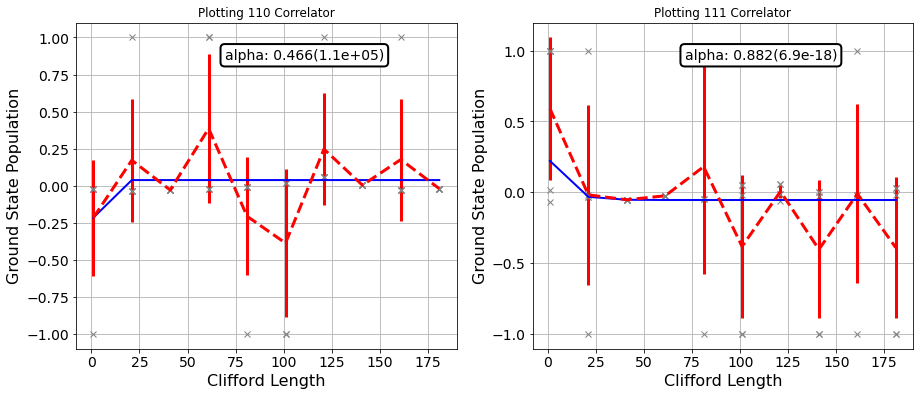

In [20]:
rbfit = CorrelatedRBFitter(None, xdata, rb_opts['rb_pattern'])

for seed_num, data in enumerate(result_corr):
    
    # Add another seed to the data
    if seed_num>-1:
        rbfit.add_data([data],rerun_fit=False)
        
rbfit.calc_data()
rbfit.calc_statistics()
rbfit.fit_data()

plt.figure(figsize=(15, 6))
axis = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]
    
for i,j in enumerate(np.arange(5,7)):
    pattern_ind = j

    # Plot the essence by calling plot_rb_data
    rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

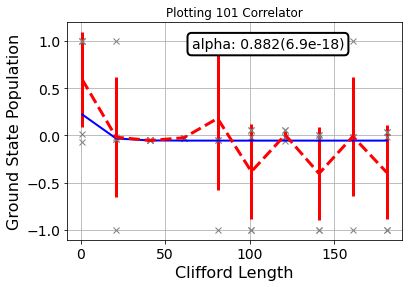

In [21]:
rbfit.plot_rb_data(4, add_label=True, show_plt=True)

In [22]:
#These are the decay parameters from the fit
rbfit.fit_alphas

{'001': 0.46735036632215077,
 '010': 0.9999999999221793,
 '011': 0.4673360319768322,
 '100': 0.4660968657445093,
 '101': 0.8819842995475143,
 '110': 0.4660785253617932,
 '111': 0.8819842995475142}

### Fit the alphas to a depolarizing map

In [23]:
rbfit.fit_alphas_to_epsilon()

0.11496627053569067

In [24]:
rbfit.fit_epsilon

{'001': [6.421587174979393e-51, 0.29950236592968177],
 '010': [1.7362469559750058e-05, 0.29949456798216945],
 '011': [2.932845169833271e-18, 0.4235566313643723],
 '100': [5.69694290024386e-38, 0.29950236592968177],
 '101': [0.39482314859617085, 0.23514732757136286],
 '110': [3.2999540690116816e-18, 0.42355663136437244],
 '111': [5.486347944611487e-05, 0.5343174446500917]}

In [25]:
#These are the calculated decay parameters given the depolarizing probabilities 
#that the fitter returned
rbfit._calc_alphas([rbfit.fit_epsilon[i][0] for i in rbfit._subsystems])

array([0.60514365, 0.99992778, 0.60513314, 0.60514365, 0.60514365,
       0.60513314, 0.60513314])

Text(0.5, 1.0, 'Qubits [0, 1, 2] on Backend qasm_simulator')

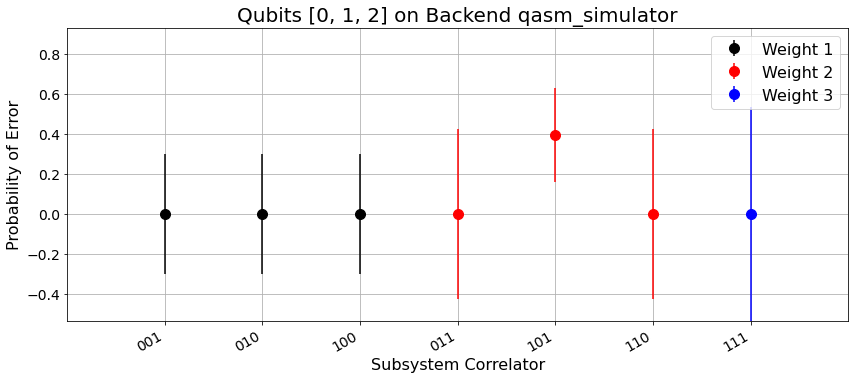

In [26]:
#Plot the depolarizing probabilities
fig = plt.figure(figsize=(14, 6))
rbfit.plot_epsilon(ax=fig.gca())
fig.gca().set_title("Qubits %s on Backend %s"%(str(qubit_list),backend.name()), fontsize=20)